In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import Accuracy

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


collect filenames for data

In [3]:
train = []
valid = []
test = []
for i in os.listdir("/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/training"):
  train.extend(os.listdir(os.path. join('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/training', i)))
  valid.extend(os.listdir(os.path. join('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/validation', i)))
  test.extend(os. listdir(os.path. join('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/evaluation', i)))
  print('Number of train images: {} \nNumber of validation images: {} \nNumber of test images: {}'.format(len(train),len(valid),len(test)))


Number of train images: 280 
Number of validation images: 96 
Number of test images: 96
Number of train images: 989 
Number of validation images: 328 
Number of test images: 327
Number of train images: 2314 
Number of validation images: 777 
Number of test images: 759
Number of train images: 3162 
Number of validation images: 1103 
Number of test images: 1046
Number of train images: 4017 
Number of validation images: 1450 
Number of test images: 1349
Number of train images: 5517 
Number of validation images: 1950 
Number of test images: 1849
Number of train images: 5957 
Number of validation images: 2097 
Number of test images: 1996
Number of train images: 6943 
Number of validation images: 2424 
Number of test images: 2331
Number of train images: 8443 
Number of validation images: 2924 
Number of test images: 2831
Number of train images: 8872 
Number of validation images: 3068 
Number of test images: 2979
Number of train images: 9866 
Number of validation images: 3430 
Number of test 

# TASK #3: PERFORM DATA EXPLORATION AND DATA VISUALIZATION

Visualize Images

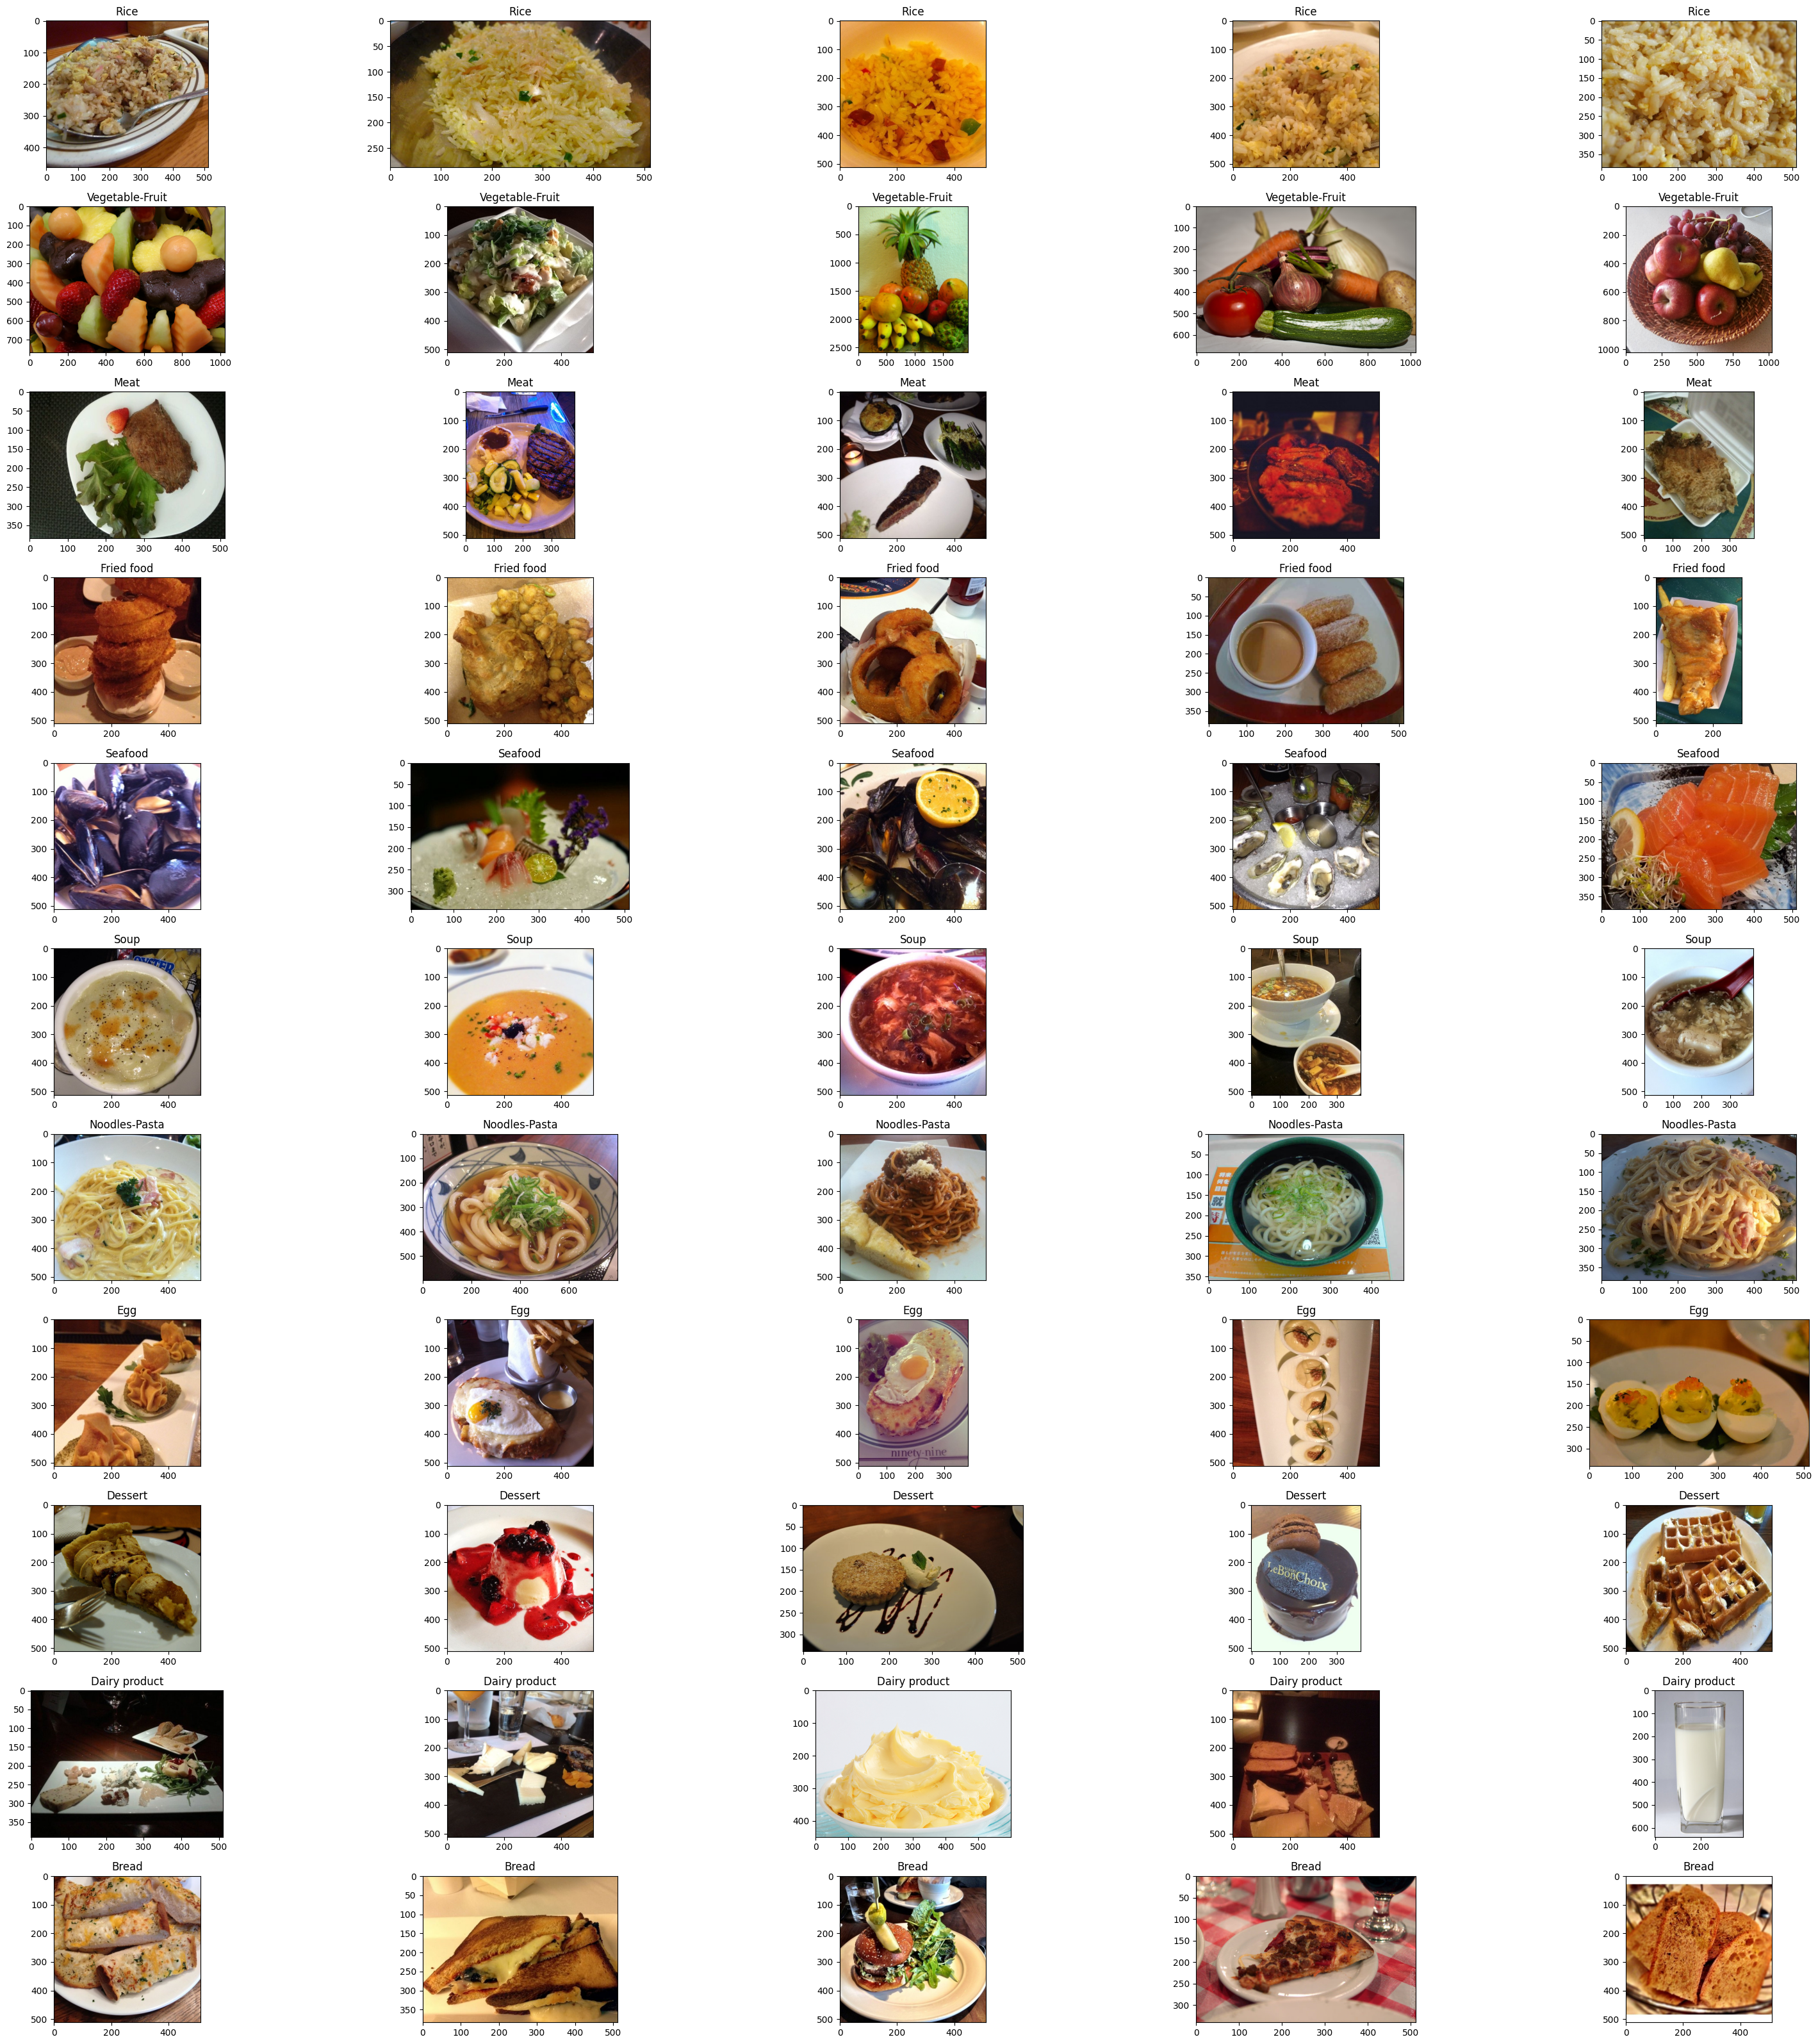

In [4]:
fig, axs = plt.subplots(11, 5, figsize = (32,32))
count = 0
for i in os.listdir('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/training'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/training', i))

  for j in range(5):
    img = os.path.join('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/training', i, train_class[j])
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(PIL.Image.open(img))
  count += 1

fig.tight_layout()

visualize food class distribution

In [5]:
No_images_per_class = []
Class_name = []
for i in os.listdir('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/training'):
  Class_name.append(i)
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/training',i))
  No_images_per_class.append(len(train_class))

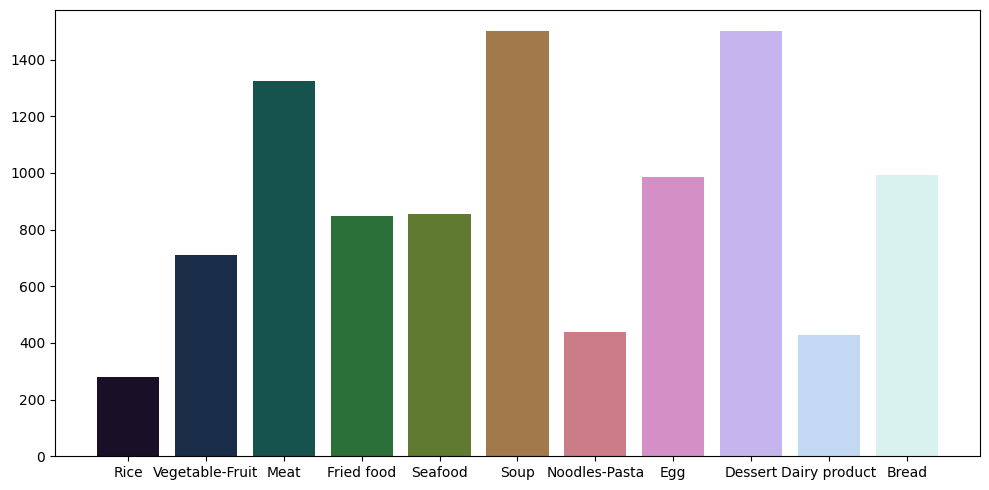

In [6]:
fig = plt.figure(figsize=(10,5))
plt.bar(Class_name, No_images_per_class, color = sns.color_palette("cubehelix",len(Class_name)))
fig.tight_layout()

# TASK #4: PERFORM IMAGE AUGMENTATION AND CREATE DATA GENERATOR

normalize dataset and add shear angle, zooming range and horizontal flip to training data

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

create data generators

In [8]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/training',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 9866 images belonging to 11 classes.


In [9]:
validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/validation',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/evaluation',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


load inception resnetv2 model for transfer learning

In [10]:
basemodel = InceptionResNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

219055592/219055592 [==============================] - 11s 0us/step


In [11]:
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_norm

freeze basemodel weights

In [12]:
basemodel.trainable = False

Add classification head to model

In [13]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D (name = 'global_average_pool') (headmodel)
headmodel = Flatten(name = 'flatten') (headmodel)
headmodel = Dense (256, activation= 'relu', name = 'dense_1') (headmodel)
headmodel = Dropout (0.3) (headmodel)
headmodel = Dense (128, activation= 'relu', name = 'dense_2') (headmodel)
headmodel = Dropout (0.3) (headmodel)
headmodel = Dense (11, activation= 'softmax', name = 'dense_3') (headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

compile model

In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(lr = 0.01, momentum = 0.9), metrics = ['accuracy'])

add early stopping and model checkpoints

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/weights.hdf5", verbose=1, save_best_only=True)

train classification head

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 1, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer, earlystopping])

308/308 [==============================] - ETA: 0s - loss: 0.9197 - accuracy: 0.7066 
Epoch 1: val_loss improved from inf to 0.67599, saving model to /content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 5588s 18s/step - loss: 0.9197 - accuracy: 0.7066 - val_loss: 0.6760 - val_accuracy: 0.7865


unfreeze base model weights for fine-tuning

In [16]:
basemodel.trainable = True

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

add callacks for fine-tuning model

In [18]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/weights_fine.hdf5", verbose=1, save_best_only=True)

fine-tune model

In [19]:
model.load_weights('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/weights.hdf5')

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr = 0.0001, momentum = 0.9), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 10, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer, earlystopping])

Epoch 1/10
 43/308 [===>..........................] - ETA: 1:09:44 - loss: 1.0199 - accuracy: 0.6810

Evaluate Model

In [ ]:
model.load_weights('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/weights_fine.hdf5')

In [ ]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)
print('Accuracy Test : {}'.format(evaluate[1]))

Assign labels

In [ ]:
labels = {0: 'Bread', 1: 'Dairy product', 2: 'Dessert', 3:'Egg', 4: 'Fried food', 5:'Meat',6:'Noodles-Pasta',7:'Rice', 8:'Seafood',9:'Soup',10: 'Vegetable-Fruit'}

Visualize images and predictions

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []
count = 0
for i in os.listdir('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/evaluation'):
  for item in os.listdir(os.path.join('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/evaluation',i)):
    img= PIL.Image.open(os.path.join('/content/drive/MyDrive/code/Transfer-Learning-for-food-classfication/food11/evaluation',i,item))
    img = img.resize((256,256))
    image.append(img)
    img = np.asarray(img, dtype= np.float32)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(labels[predict])
    original.append(i)


Get test accuracy

In [ ]:
Accuracy(labels=original,predictions=prediction)

visualize results

In [ ]:
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

get classfication report

In [ ]:
print(classification_report (np.asarray (original), np.array (prediction)))

plot confusion matrix

In [ ]:
plt.figure(figsize=(20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')
